***Sacramento Crime Data (Jan 2006)***



**Getting Started**

Loading Python session, importing PySpark, and loading respective Spark packages. Declaring Spark Session for pulling and analyzing data:

In [3]:
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *

import sys
import os
import matplotlib.pyplot as plt
import pandas as pd

if __name__ == '__main__':
    scSpark = SparkSession \
        .builder \
        .appName("reading csv") \
        .getOrCreate()

**Loading Data**

Loading in sample data as dataframe provided from email and creating view for analysis from table:


In [4]:
data_file = 'D:\ThomasData\Documents\crime.csv'
df = scSpark.read.csv(data_file, header=True, sep=",").cache()
df.createOrReplaceTempView("crime")

**Understanding the Dataset**

Let's take a look at the headers and the top 10 rows of this dataset. This will give us a better sense of what we're working with:


In [5]:
sqlDF_10 = scSpark.sql("SELECT cdatetime, address, district, beat, grid, crimedescr, ucr_ncic_code, latitude, longitude FROM crime limit 10")
sqlDF_10.show()

+-------------+-------------------+--------+----------+----+--------------------+-------------+-----------+------------+
|    cdatetime|            address|district|      beat|grid|          crimedescr|ucr_ncic_code|   latitude|   longitude|
+-------------+-------------------+--------+----------+----+--------------------+-------------+-----------+------------+
|1/1/2006 0:00| 3108 OCCIDENTAL DR|       3|3C        |1115|10851(A)VC TAKE V...|         2404|38.55042047|-121.3914158|
|1/1/2006 0:00|2082 EXPEDITION WAY|       5|5A        |1512|459 PC  BURGLARY ...|         2204|38.47350069|-121.4901858|
|1/1/2006 0:00|         4 PALEN CT|       2|2A        | 212|10851(A)VC TAKE V...|         2404|38.65784584|-121.4621009|
|1/1/2006 0:00|     22 BECKFORD CT|       6|6C        |1443|476 PC PASS FICTI...|         2501|38.50677377|-121.4269508|
|1/1/2006 0:00|   3421 AUBURN BLVD|       2|2A        | 508|459 PC  BURGLARY-...|         2299| 38.6374478|-121.3846125|
|1/1/2006 0:00| 5301 BONNIEMAE W

**Saving as a Table**

Let's save this dataframe as a table to our current file path:

In [ ]:
df.write.saveAsTable("crimes")

**Understanding Crime Locations**

Observing the top 10 addresses with the most amount of crimes that occured:

In [7]:
scSpark.sql("SELECT count(cdatetime) as Crime_Count, address FROM crime GROUP BY address ORDER BY Crime_Count DESC LIMIT 10").show()

+-----------+--------------------+
|Crime_Count|             address|
+-----------+--------------------+
|         47|    3555 AUBURN BLVD|
|         31|      1689 ARDEN WAY|
|         29|  5770 FREEPORT BLVD|
|         26| 2750 SUTTERVILLE RD|
|         23|       2250 68TH AVE|
|         21|      1695 ARDEN WAY|
|         20|       6879 14TH AVE|
|         18|            715 L ST|
|         16|FRANKLIN BLVD / F...|
|         16|      3500 FLORIN RD|
+-----------+--------------------+



**Understanding Crime Locations (Cont.)**

Observing the amount of crimes that occured in each district:

In [8]:
scSpark.sql("SELECT count(cdatetime) as Crime_Count, district FROM crime GROUP BY district ORDER BY Crime_Count DESC").show()

+-----------+--------+
|Crime_Count|district|
+-----------+--------+
|       1575|       3|
|       1462|       2|
|       1359|       6|
|       1161|       4|
|       1159|       5|
|        868|       1|
+-----------+--------+



**Understanding Crime Types**

I would like to see the count of crime occurrences by the description of the actual crimes. Firstly, we should check how many different types of crimes that occurred so we can understand the variation of crime types. 

Secondly, let's take a look at the top 20 crimes committed:

In [9]:
scSpark.sql("SELECT count(distinct(crimedescr)) as DistinctCrimeType_Count FROM crime ").show()
scSpark.sql("SELECT count(cdatetime) as Crime_Count, crimedescr FROM crime GROUP BY crimedescr ORDER BY Crime_Count DESC LIMIT 20").show()

+-----------------------+
|DistinctCrimeType_Count|
+-----------------------+
|                    304|
+-----------------------+

+-----------+--------------------+
|Crime_Count|          crimedescr|
+-----------+--------------------+
|        653|10851(A)VC TAKE V...|
|        463|TOWED/STORED VEH-...|
|        462|459 PC  BURGLARY ...|
|        434|TOWED/STORED VEHICLE|
|        356|459 PC  BURGLARY ...|
|        268|      MISSING PERSON|
|        223|10851 VC AUTO THE...|
|        195|594(B)(2)(A) VAND...|
|        182|TRAFFIC-ACCIDENT ...|
|        175|TRAFFIC-ACCIDENT-...|
|        135|459 PC  BURGLARY ...|
|        119|484 PETTY THEFT/L...|
|        117|594(B)(1)PC  VAND...|
|        116|     CASUALTY REPORT|
|        106|5150 WI DANGER SE...|
|        103|    20002(A) HIT/RUN|
|         99|211 PC  ROBBERY U...|
|         99|11364 HS POSS DRU...|
|         99|484 PC   PETTY TH...|
|         90|NON INJ HR/MAIL O...|
+-----------+--------------------+



**Understanding Crime Types (Cont.)**

Well, the above table is not as helpful as I would have liked. These crime type descriptions are supplemented with some type of alphanumeric codes, including numbers, letter combinations, and parathenses. I think we should clean this data to continue our analysis. Let's take a stab by using the *trim, substring, and if statements* found in *Spark SQL*:


In [10]:
descrSub = scSpark.sql("SELECT crimedescr, trim(trim(LEADING 'C' FROM trim(substring(crimedescr, IF(locate('VC',crimedescr) > locate('PC',crimedescr) AND locate('VC',crimedescr) > locate(')',crimedescr), locate('VC',crimedescr), IF(locate(')',crimedescr) > locate('PC',crimedescr) AND locate(')',crimedescr) > locate('VC',crimedescr), locate(')',crimedescr), locate('PC',crimedescr)))+1)))) AS crimeDescrFixed, cdatetime, district, address FROM crime")
descrSub.createOrReplaceTempView("crimeDescrClean_1")
scSpark.sql("SELECT * FROM crimeDescrClean_1 LIMIT 5").show()
scSpark.sql("SELECT count(cdatetime) AS Crime_Count, crimeDescrFixed FROM crimeDescrClean_1 GROUP BY crimeDescrFixed ORDER BY Crime_Count DESC LIMIT 20").show()


+--------------------+--------------------+-------------+--------+-------------------+
|          crimedescr|     crimeDescrFixed|    cdatetime|district|            address|
+--------------------+--------------------+-------------+--------+-------------------+
|10851(A)VC TAKE V...|  TAKE VEH W/O OWNER|1/1/2006 0:00|       3| 3108 OCCIDENTAL DR|
|459 PC  BURGLARY ...|  BURGLARY RESIDENCE|1/1/2006 0:00|       5|2082 EXPEDITION WAY|
|10851(A)VC TAKE V...|  TAKE VEH W/O OWNER|1/1/2006 0:00|       2|         4 PALEN CT|
|476 PC PASS FICTI...|PASS FICTICIOUS C...|1/1/2006 0:00|       6|     22 BECKFORD CT|
|459 PC  BURGLARY-...|BURGLARY-UNSPECIFIED|1/1/2006 0:00|       2|   3421 AUBURN BLVD|
+--------------------+--------------------+-------------+--------+-------------------+

+-----------+--------------------+
|Crime_Count|     crimeDescrFixed|
+-----------+--------------------+
|        653|  TAKE VEH W/O OWNER|
|        463|TOWED/STORED VEH-...|
|        462|    BURGLARY VEHICLE|
|     

**Understanding Crime Types (Cont.)**

Not bad - I see we still have a little bit more data cleansing to do as there are remaining prefacing integers. If presenting this type of information to client stakeholders, we should ensure these are removed so intuitive assumptions can be made about the data; and, the analyzed data is as clear as possible. Let's leverage the *cast* command in *Spark SQL* to identify integers that preface a description, then remove these from the description with conditional logic:


In [22]:
scSpark.sql("SELECT count(cdatetime) As Crime_Count, if(cast(substring(crimeDescrFixed,0,1) as int) IS NULL, crimeDescrFixed, substring(crimeDescrFixed,locate(' ', crimeDescrFixed))) AS crimeDescrFixed FROM crimeDescrClean_1 GROUP BY crimeDescrFixed ORDER BY Crime_Count DESC LIMIT 20").show()
descrSub_2 = scSpark.sql("SELECT crimedescr, if(cast(substring(crimeDescrFixed,0,1) as int) IS NULL, crimeDescrFixed, substring(crimeDescrFixed,locate(' ', crimeDescrFixed))) AS crimeDescrFixed, cdatetime, address, district, address FROM crimeDescrClean_1")
descrSub_2.createOrReplaceTempView("crimeDescrClean_2")


+-----------+--------------------+
|Crime_Count|     crimeDescrFixed|
+-----------+--------------------+
|        653|  TAKE VEH W/O OWNER|
|        463|TOWED/STORED VEH-...|
|        462|    BURGLARY VEHICLE|
|        434|TOWED/STORED VEHICLE|
|        356|  BURGLARY RESIDENCE|
|        268|      MISSING PERSON|
|        223|   AUTO THEFT LOCATE|
|        195|(2)(A) VANDALISM/...|
|        182|TRAFFIC-ACCIDENT ...|
|        175|TRAFFIC-ACCIDENT-...|
|        135|   BURGLARY BUSINESS|
|        119| PETTY THEFT/LICE...|
|        117|     VANDALISM +$400|
|        116|      ASUALTY REPORT|
|        106| WI DANGER SELF/O...|
|        103|             HIT/RUN|
|         99| HS POSS DRUG PARAPH|
|         99| ROBBERY UNSPECIFIED|
|         99|  PETTY THEFT/INSIDE|
|         90|NON INJ HR/MAIL O...|
+-----------+--------------------+




Just like that - we have a clean crime description column with little to no prefacing characters.. which ultimately removes obscurity in the meaning of the category. I've also initialized a new table with the cleanest possible descriptions. We could hypothetically write this dataframe as a new table to our workspace to use for later using *Spark's* write function.


**Additional Analysis**

Now that we've conducted some basic exploratory analysis, I'd like to see how *burglaries* occur throughout the month of January - (considering they are some of the most frequently committed crimes in this city). This will require some data cleansing / aggregation; luckily, PySpark includes a mapping to a pandas dataframe. Let's get started:

In [21]:
scSpark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
dailyBurglary = scSpark.sql("SELECT cdatetime, TO_DATE(cast(UNIX_TIMESTAMP(substring(cdatetime,0,locate(' ', cdatetime) - 1), 'MM/dd/yyyy') AS TIMESTAMP)) as dayCommitted, crimeDescrFixed FROM crimeDescrClean_2 WHERE crimeDescrFixed LIKE '%BURGLARY%'")
dailyBurglary.show()
dailyBurglaryAgg = scSpark.sql("SELECT cast(count(cdatetime) as int) As Burglary_Count, TO_DATE(cast(UNIX_TIMESTAMP(substring(cdatetime,0,locate(' ', cdatetime) - 1), 'MM/dd/yyyy') AS TIMESTAMP)) as dayCommitted, cast(dayofweek(TO_DATE(cast(UNIX_TIMESTAMP(substring(cdatetime,0,locate(' ', cdatetime) - 1), 'MM/dd/yyyy') AS TIMESTAMP))) as int) as DayofWeek FROM crimeDescrClean_2 WHERE crimeDescrFixed LIKE '%BURGLARY%' GROUP BY dayCommitted ORDER BY dayCommitted")
print("Aggregating filtered dataset into daily counts")
dailyBurglaryAgg.show()
dailyBurglaryAgg.createOrReplaceTempView("dba")

dfBA = dailyBurglaryAgg.toPandas()

+--------------+------------+--------------------+
|     cdatetime|dayCommitted|     crimeDescrFixed|
+--------------+------------+--------------------+
| 1/1/2006 0:00|  2006-01-01|  BURGLARY RESIDENCE|
| 1/1/2006 0:00|  2006-01-01|BURGLARY-UNSPECIFIED|
| 1/1/2006 0:00|  2006-01-01|    BURGLARY VEHICLE|
| 1/1/2006 0:00|  2006-01-01|   BURGLARY BUSINESS|
| 1/1/2006 0:01|  2006-01-01|    BURGLARY VEHICLE|
| 1/1/2006 0:01|  2006-01-01|    BURGLARY VEHICLE|
| 1/1/2006 0:01|  2006-01-01|  BURGLARY RESIDENCE|
| 1/1/2006 0:36|  2006-01-01|   BURGLARY BUSINESS|
| 1/1/2006 1:00|  2006-01-01|    BURGLARY VEHICLE|
| 1/1/2006 1:00|  2006-01-01|    BURGLARY VEHICLE|
| 1/1/2006 1:06|  2006-01-01|  BURGLARY RESIDENCE|
| 1/1/2006 3:28|  2006-01-01|  BURGLARY RESIDENCE|
| 1/1/2006 4:00|  2006-01-01|    BURGLARY VEHICLE|
| 1/1/2006 4:00|  2006-01-01|    BURGLARY VEHICLE|
| 1/1/2006 7:00|  2006-01-01|  BURGLARY RESIDENCE|
| 1/1/2006 7:45|  2006-01-01|    BURGLARY VEHICLE|
| 1/1/2006 8:00|  2006-01-01|  

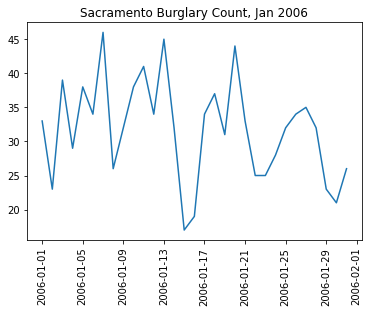

In [23]:
dfBA.describe()
plt.plot(dfBA['dayCommitted'],dfBA['Burglary_Count'])
plt.title("Sacramento Burglary Count, Jan 2006")
_=plt.xticks(rotation=90) 


**Additional Analysis**

This looks like burglaries happen in an almost weekly pattern; it appears there's an uptick, then a drop. Let's take one more further look:

Text(0.5, 0, 'Day of Week; 1 = Sunday, 2 = Monday, ...')

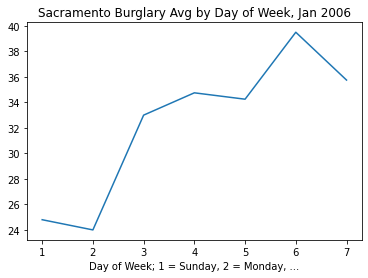

In [19]:
dowB = scSpark.sql("SELECT avg(Burglary_Count) As Burglary_CountAVG, DayofWeek FROM dba GROUP BY DayofWeek ORDER BY DayofWeek").toPandas()
plt.plot(dowB['DayofWeek'],dowB['Burglary_CountAVG'])
plt.title("Sacramento Burglary Avg by Day of Week, Jan 2006")
plt.xlabel("Day of Week; 1 = Sunday, 2 = Monday, ...")



It appears that burglaries start to pick up after **Monday**; and, the two most frequent days for burglarly are **Friday and Saturday**. This follows the time series pattern we just observed. Let's continue.

**Data Enrichment**

I will continue with the same burglary subset of data, but also merge a *public Sacramento weather dataset* to further our analysis:


In [20]:
data_file = 'D:\ThomasData\Documents\weather.csv'
dfw = scSpark.read.csv(data_file, header=True, sep=",").cache()
dfw.createOrReplaceTempView("weather")
dfw.show()
dfw2 = scSpark.sql("SELECT TO_DATE(cast(UNIX_TIMESTAMP(Date, 'MM/dd/yyyy') AS TIMESTAMP)) as dayCommitted, Avg FROM weather")
dfw2.createOrReplaceTempView("weather")
dfw2.show()
compare = scSpark.sql("SELECT weather.dayCommitted, weather.Avg, dba.Burglary_Count FROM weather, dba WHERE weather.dayCommitted = dba.dayCommitted").toPandas()
print("Merging the two datasets together with Apache Spark SQL")
compare.head()

+---------+---+----+---+
|     Date|Max| Avg|Min|
+---------+---+----+---+
| 1/1/2006| 57|51.2| 47|
| 1/2/2006| 52|50.3| 46|
| 1/3/2006| 55|50.5| 46|
| 1/4/2006| 60|51.3| 46|
| 1/5/2006| 62|46.9| 40|
| 1/6/2006| 53|46.8| 39|
| 1/7/2006| 61|53.2| 48|
| 1/8/2006| 56|45.4| 38|
| 1/9/2006| 57|43.6| 35|
|1/10/2006| 56|42.8| 36|
|1/11/2006| 55|49.6| 43|
|1/12/2006| 55|48.2| 45|
|1/13/2006| 55|51.4| 48|
|1/14/2006| 54|50.2| 41|
|1/15/2006| 53|43.9| 36|
|1/16/2006| 53|45.8| 37|
|1/17/2006| 55|  48| 41|
|1/18/2006| 55|46.7| 39|
|1/19/2006| 54|40.7| 34|
|1/20/2006| 53|  40| 30|
+---------+---+----+---+
only showing top 20 rows

+------------+----+
|dayCommitted| Avg|
+------------+----+
|  2006-01-01|51.2|
|  2006-01-02|50.3|
|  2006-01-03|50.5|
|  2006-01-04|51.3|
|  2006-01-05|46.9|
|  2006-01-06|46.8|
|  2006-01-07|53.2|
|  2006-01-08|45.4|
|  2006-01-09|43.6|
|  2006-01-10|42.8|
|  2006-01-11|49.6|
|  2006-01-12|48.2|
|  2006-01-13|51.4|
|  2006-01-14|50.2|
|  2006-01-15|43.9|
|  2006-01-16|

,dayCommitted,Avg,Burglary_Count
0,2006-01-24,41,28
1,2006-01-22,48.6,25
2,2006-01-18,46.7,37
3,2006-01-20,40,44
4,2006-01-06,46.8,34


**Data Enrichment**

Let's check to see if there is any correlation between the *average temperature* and the *number of burglaries* occuring on the same day:



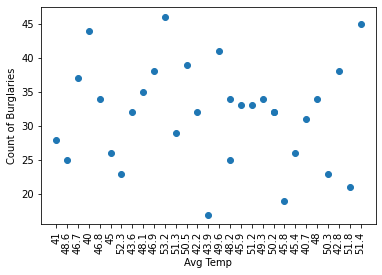

In [17]:
plt.scatter(compare['Avg'],compare['Burglary_Count'])
plt.xlabel("Avg Temp")
plt.ylabel("Count of Burglaries")
_ = plt.xticks(rotation=90)

**Analysis Conclusion**

We've loaded, explored, cleaned, and enriched a full month of crime data occurring in Sacramento within January 2006 using Apache Spark via PySpark. We've understood a couple of key points:


-The crime description comes with prefacing codes (which could be distracting in analysis), so we need to conduct robust data cleansing to drive further analysis

-It appears there were a lot of vehicles taken without the owner present, burglaries, and theft in this city within this specific month 

-We did a case study on burglaries - noticing that burglaries happen more often on weekends (at least within this given sample / time period)

-There is no correlation whatsoever between the average daily temperature and number of burglaries that occur on a day          

*Kyle Thomas; Dec 2020*